## Сверточные нейронные сети для распознавания образов; множественная классификация с набором данных MNIST

В этой главе набор MNIST будет использоваться для исследования глубокого обучения на базе сверточной нейронной сети.

Сверточные нейронные сети часто применяются в приложениях распознавания образов, например при распознавании рукописных цифр и символов, а также распознавании объектов в графических
изображениях и видео. Кроме того, они могут применяться и в других классах
приложений, например в обработке естественных языков и рекомендательных
системах.

Набор данных Digits содержит всего 1797 образцов, тогда как набор MNIST
содержит 70 000 помеченных образцов с изображениями цифр — 60 000 для
обучения и 10 000 для тестирования.

Каждый образец представляет собой изображение 28 × 28 пикселов (всего 784 признака) в оттенках серого, пред-
ставленное в виде массива NumPy. 

Каждый пиксел является значением от 0 до 255, представляющим интенсивность (оттенок) этого пиксела — набор
данных Digits использует менее точные оттенки со значениями от 0 до 16.

### Базовая нейронная сеть Keras

Нейронная сеть Keras состоит из следующих компонентов:

- Сеть (также называемая моделью) — серия уровней с нейронами, используемыми для обучения на образцах.
- Функция потерь — вычисляет метрику эффективности прогнозирования сетью целевых значений. 
- Оптимизатор — стремится минимизировать значения, сгенерированные функцией потерь, для оптимизации сети с целью повышения качества прогнозов.

### Загрузка набора данных MNIST

In [1]:
from tensorflow.keras.datasets import mnist

Функция load_data модуля mnist загружает обучающие и тестовые наборы
MNIST:

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### Исследование данных

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
y_train.shape

(60000,)

In [5]:
X_test.shape

(10000, 28, 28)

In [6]:
y_test.shape

(10000,)

### Визуализация цифр

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

In [8]:
import numpy as np
index = np.random.choice(np.arange(len(X_train)), 24, replace=False)

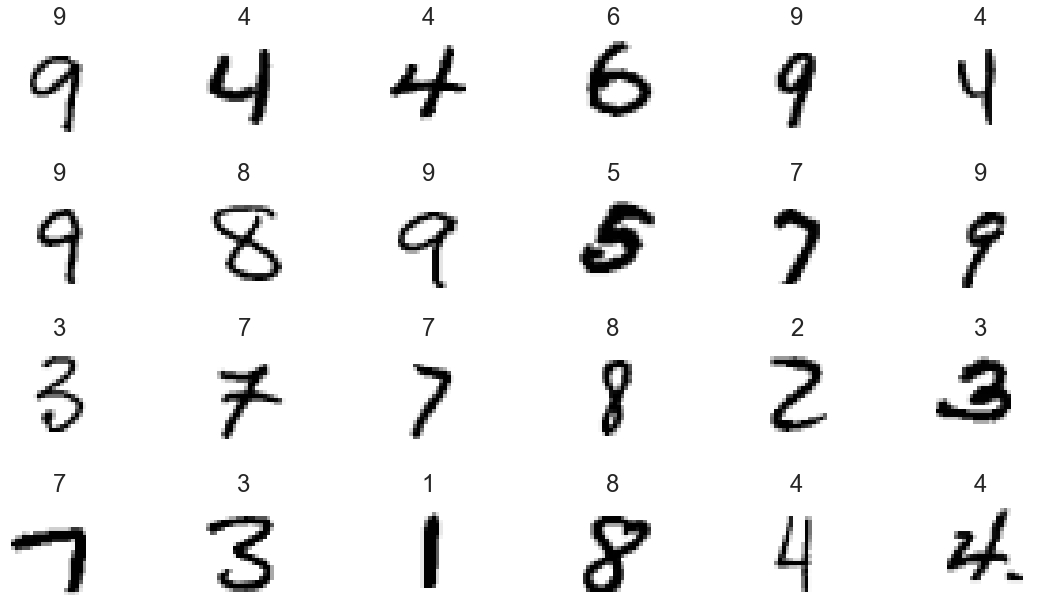

In [9]:
figure, axes = plt.subplots(nrows=4, ncols=6, figsize=(16, 9))
for item in zip(axes.ravel(), X_train[index], y_train[index]):
    axes, image, target = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_xticks([]) # remove x-axis tick marks
    axes.set_yticks([]) # remove y-axis tick marks
    axes.set_title(target)
plt.tight_layout()

#### Проблемы:
- Одни люди пишут «открытые» цифры 4 (как в первой и третьей строке), другие используют «закрытый» вариант написания (как во второй строке). И хотя все разновидности «четверки» обладают сходными характеристики, все они отличаются друг от друга.

- Цифра 3 во второй строке выглядит странно — она напоминает гибрид 6 и 7. Сравните с намного более четко прописанной цифрой 3 в четвертой строке.
- Цифру 5 во второй строке легко можно принять за 6.

- Кроме того, люди пишут цифры под разными углами, как видно из четырех цифр 6 в третьей и четвертой строках — две цифры располагаются прямо, одна наклонена влево, а другая вправо.

### Подготовка данных
Набор данных MNIST требует определенной подготовки для использования в сверточной нейронной сети Keras.

#### Переформатирование

In [10]:
X_train = X_train.reshape((60000, 28, 28, 1))

In [11]:
X_train.shape

(60000, 28, 28, 1)

In [12]:
X_test = X_test.reshape((10000, 28, 28, 1))

In [13]:
X_test.shape

(10000, 28, 28, 1)

#### Нормализация

In [14]:
X_train = X_train.astype('float32') / 255

In [15]:
X_test = X_test.astype('float32') / 255

#### Прямое унитарное кодирование: преобразование меток из целых чисел в категорийные данные

При оценке точности модели Keras сравнивает прогнозы модели с метками. Для этого Keras требует, чтобы значения имели одинаковую размерность, но метка MNIST для каждой цифры представляет собой целое значение в диапазоне 0–9. Следовательно, метки необходимо преобразовать в категорийные данные, то есть массивы категорий, соответствующие формату прогнозов. Для этого будет использоваться процесс, называемый прямым унитарным кодированием 1: данные преобразуются в массивы значений 1.0 и 0.0, в котором только один элемент равен 1.0, а остальные равны 0.0. Для MNIST в результате прямого унитарного кодирования будут получены 10-элементные массивы, представляющие категории от 0 до 9.

In [16]:
from tensorflow.keras.utils import to_categorical

In [17]:
y_train = to_categorical(y_train)

In [18]:
y_train.shape

(60000, 10)

In [19]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [20]:
y_test = to_categorical(y_test)

In [21]:
y_test.shape

(10000, 10)

### Создание нейронной сети
Начнем с модели Keras Sequential из модуля tensorflow.keras.models:

In [22]:
from tensorflow.keras.models import Sequential

In [23]:
cnn = Sequential()

Полученная сеть будет выполнять свои уровни последовательно — выход
одного уровня станет входом другого; такие сети также называются сетями
прямого распространения.

### Добавление уровней в сеть

In [24]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

### Свертка

Наша сеть будет начинаться со сверточного уровня, который использует от-
ношения между пикселами, расположенными поблизости друг к другу, для
выявления полезных признаков (или закономерностей) для малых областей
каждого образца. Эти признаки станут входными данными последующих
уровней.

На основании сверточных нейронных сетей и того факта, что изображения MNIST невелики, мы будем использо-
вать 64 фильтра в первом сверточном уровне. Набор фильтров, производимых сверточным уровнем, называется картой признаков.

### Добавление сверточного уровня

In [25]:
cnn.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
input_shape=(28, 28, 1)))

Уровень Conv2D настраивается следующими аргументами:
- filters=64 — количество фильтров в итоговой карте признаков;
- kernel_size=(3, 3) — размер ядра, используемого в каждом фильтре;
- activation='relu' — для получения вывода уровня используется функция активации 'relu' (Rectified Linear Unit). 'relu' — наиболее часто используемая функция активации в современных сетях глубокого обучения; она просто вычисляется, что хорошо отражается на быстродействии. Чаще всего для сверточных уровней рекомендуется использоватьименно эту функцию.

### Добавление объединяющего уровня

Для предотвращения чрезмерной подгонки и сокращения времени вычис-
лений за сверточным уровнем часто следует один или несколько уровней,
сокращающих степень размерности выходных данных сверточного уровня.
Объединяющий уровень сжимает результаты, отбрасывая признаки, вслед-
ствие чего модель становится более общей.

In [26]:
cnn.add(MaxPooling2D(pool_size=(2, 2)))

### Добавление еще одного сверточного уровня и объединяющего уровня
Сверточные нейронные сети часто содержат много сверточных и объединяющих уровней. Сверточные сети Keras обычно удваивают количество фильтров в последующих сверточных уровнях, чтобы модель могла извлечь больше связей между признаками
. Добавим второй сверточный уровень со 128 фильтрами, за которым следует второй объединяющий уровень для сокращения
степени размерности на 75%:

In [27]:
cnn.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))

In [28]:
cnn.add(MaxPooling2D(pool_size=(2, 2)))

### Одномерное преобразование результатов

На текущий момент выход предыдущего уровня является трехмерным
(5 × 5 × 128), но на выходе модель должна выдавать одномерный массив 10 вероятностей классификации цифр. Для подготовки одномерных прогнозов
сначала необходимо преобразовать трехмерный выход предыдущего уровня
к одному измерению.

In [29]:
cnn.add(Flatten())

### Добавление уровня Dense для сокращения количества признаков

Теперь необходимо взять все эти признаки и изучить отношения между ними, чтобы
наша модель могла определить, какую цифру представляет то или иное изображение. Изучение отношений между признаками и проведение классификации достигается в полносвязных уровнях Dense

In [30]:
cnn.add(Dense(units=128, activation='relu'))

### Добавление еще одного уровня Dense для получения итогового результата

Последним уровнем нашей сети будет уровень Dense, который классифицирует
свои входные данные по нейронам, представляющим классы от 0 до 9.

In [31]:
cnn.add(Dense(units=10, activation='softmax'))

### Вывод сводной информации модели

Метод summary модели выводит информацию об уровнях модели. В частности,
здесь можно найти интересную информацию о размерах выходных данных разных уровней и количестве параметров.

In [32]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               409728    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

### Визуализация структуры модели

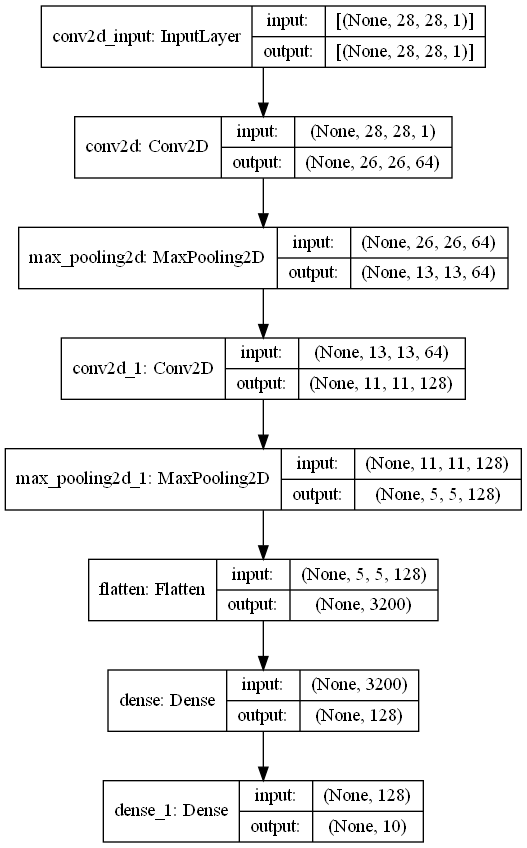

In [37]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import pydot
plot_model(cnn, to_file='convnet.png', show_shapes=True, show_layer_names=True)
Image(filename='convnet.png')

### Компиляция модели

In [38]:
cnn.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

Аргументы: 

- optimizer='adam' — оптимизатор, используемый моделью для регулировки весов в нейронной сети в процессе обучения. 
- loss='categorical_crossentropy' — функция потерь, используемая оптимизатором в сетях множественной классификации (таких, как наша сверточная сеть), которая будет прогнозировать 10 классов.
- metrics=['accuracy'] — список метрик, которые будут производиться сетью, для того чтобы упростить оценку модели. 

### Обучение и оценка модели

По аналогии с моделями scikit-learn обучим модель Keras вызовом ее метода fit:

In [40]:
cnn.fit(X_train, y_train, epochs=5, batch_size=64,
validation_split=0.1)

Epoch 1/5
844/844 [==============================] - 35s 40ms/step - loss: 0.1423 - accuracy: 0.9569 - val_loss: 0.0434 - val_accuracy: 0.9880
Epoch 2/5
844/844 [==============================] - 33s 39ms/step - loss: 0.0429 - accuracy: 0.9864 - val_loss: 0.0328 - val_accuracy: 0.9910
Epoch 3/5
844/844 [==============================] - 33s 39ms/step - loss: 0.0273 - accuracy: 0.9916 - val_loss: 0.0339 - val_accuracy: 0.9900
Epoch 4/5
844/844 [==============================] - 32s 38ms/step - loss: 0.0218 - accuracy: 0.9926 - val_loss: 0.0388 - val_accuracy: 0.9900
Epoch 5/5
844/844 [==============================] - 32s 38ms/step - loss: 0.0144 - accuracy: 0.9954 - val_loss: 0.0419 - val_accuracy: 0.9893


В процессе обучения метод fit выводит различную информацию: прогресс
каждой эпохи, длительность выполнения эпохи (в нашем случае каждая занимала 63–70 секунд) и оценочные метрики для текущего прохода. В последней
эпохе этой модели точность достигла 99,48% для обучающих образцов (acc) и 99,27% для проверочных образцов (val_acc). Впечатляющие показатели,
особенно если учесть, что мы еще не пытались настраивать гиперпараметры
или подбирать количество и типы уровней, что может улучшить (или ухудшить) результаты.

### Оценка модели

In [42]:
loss, accuracy = cnn.evaluate(X_test, y_test)

313/313 [==============================] - 3s 10ms/step - loss: 0.0395 - accuracy: 0.9889


In [43]:
loss

0.03945642337203026

In [44]:
accuracy

0.9889000058174133

Из этого вывода следует, что наша модель сверточных нейронных сетей обеспечивает точность 98,89%

### Построение прогнозов

In [46]:
predictions = cnn.predict(X_test)

In [47]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [49]:
for index, probability in enumerate(predictions[0]):
    print(f'{index}: {probability:.10%}')

0: 0.0000000021%
1: 0.0000000034%
2: 0.0000000565%
3: 0.0000001184%
4: 0.0000000002%
5: 0.0000000000%
6: 0.0000000000%
7: 100.0000000000%
8: 0.0000000002%
9: 0.0000002633%


Согласно этим результатам, predictions[0] показывает, что по мнению нашей
модели образец представляет цифру 7 с почти 100-процентной вероятностью.

### Поиск неправильных прогнозов

На следующем шаге стоит просмотреть несколько неправильно спрогнозированных изображений, чтобы понять, с какими изображениями у нашей
модели возникли трудности.

In [50]:
images = X_test.reshape((10000, 28, 28))
incorrect_predictions = []
for i, (p, e) in enumerate(zip(predictions, y_test)):
    predicted, expected = np.argmax(p), np.argmax(e)
    if predicted != expected:
        incorrect_predictions.append(
        (i, images[i], predicted, expected))

In [51]:
len(incorrect_predictions)

111

### Визуализация ошибочных предсказаний

Следующий фрагмент выводит 24 неправильных изображения с указанием индекса каждого изображения (index), прогнозируемого значения (p) и ожидаемого значения (e):

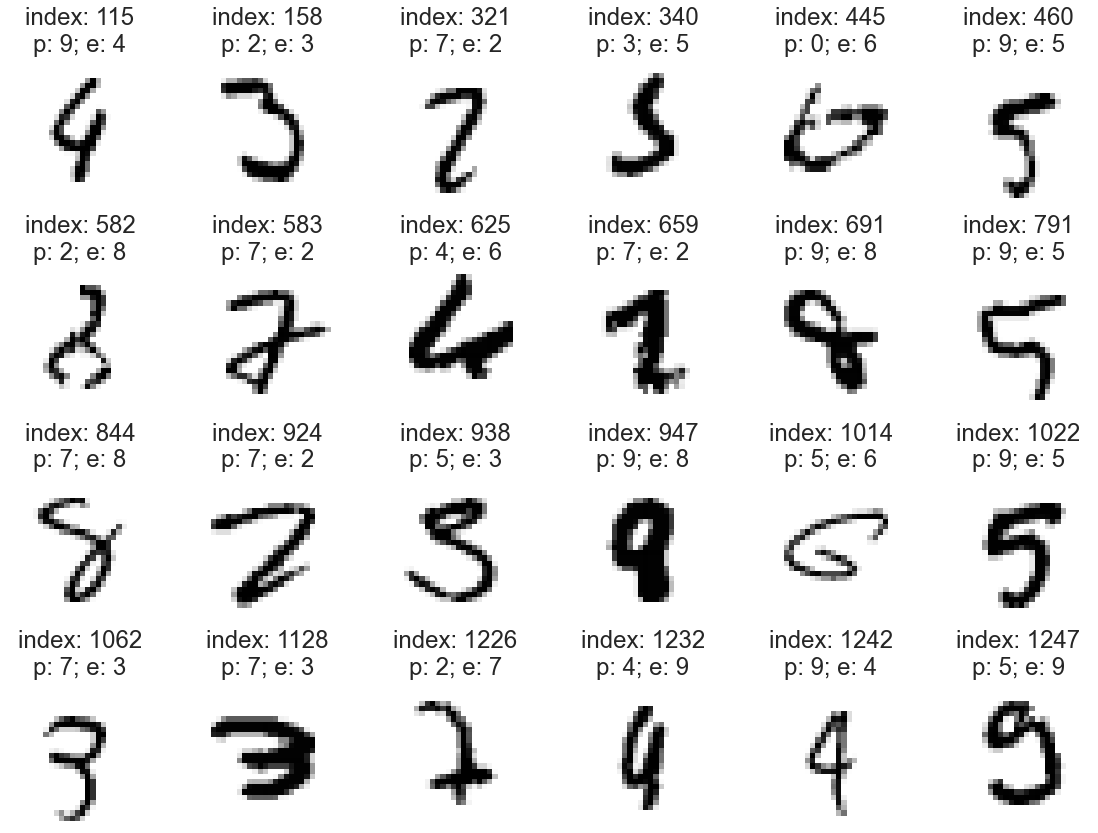

In [52]:
figure, axes = plt.subplots(nrows=4, ncols=6, figsize=(16, 12))
for axes, item in zip(axes.ravel(), incorrect_predictions):
    index, image, predicted, expected = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_xticks([]) # remove x-axis tick marks
    axes.set_yticks([]) # remove y-axis tick marks
    axes.set_title(
        f'index: {index}\np: {predicted}; e: {expected}')
plt.tight_layout()

### Вывод вероятностей для нескольких ошибочных прогнозов

In [54]:
def display_probabilities(prediction):
    for index, probability in enumerate(prediction):
        print(f'{index}: {probability:.10%}')

In [58]:
display_probabilities(predictions[321])

0: 0.0000076398%
1: 0.0000732311%
2: 0.2033660188%
3: 0.0000625706%
4: 0.0000000000%
5: 0.0000000001%
6: 0.0000000000%
7: 99.7964859009%
8: 0.0000042795%
9: 0.0000028421%


In [59]:
display_probabilities(predictions[340])

0: 0.0000627625%
1: 0.0147579063%
2: 0.0002282164%
3: 63.6893808842%
4: 0.1125552109%
5: 36.1665010452%
6: 0.0052593492%
7: 0.0000000342%
8: 0.0036041441%
9: 0.0076488352%


In [60]:
display_probabilities(predictions[691])

0: 0.0000016863%
1: 0.0001999492%
2: 0.0001506744%
3: 0.0000000591%
4: 14.2953470349%
5: 0.0004259221%
6: 0.0000012368%
7: 0.0635467528%
8: 41.7274951935%
9: 43.9128339291%


### Сохранение и загрузка модели

Обучение моделей нейронных сетей может потребовать значительного времени. После того как вы спроектируете и протестируете подходящую модель,
можно сохранить ее состояние. Это позволит вам загрузить ее в будущем
для построения новых прогнозов.

In [61]:
cnn.save('mnist_cnn.h5')

Сохраненную модель можно загрузить функцией load_model из модуля
tensorflow.keras.models:

In [62]:
from tensorflow.keras.models import load_model
cnn = load_model('mnist_cnn.h5')